In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(reticulate)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
}))


In [2]:
options(reticulate.conda_binary = "sofftware/anaconda3/bin/conda")
library(reticulate)
use_condaenv("R42")
source_python("mixture.py")
source("helper_functions_for_diffex.r")

Loading required package: limma


Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA




# Definitions etc

In [3]:
set.seed(1234)
options(digits=2)
stats <- c()

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    secondary_a_path = "S1/analysis/secondary/"
    save_seurat_h5 = "YES"
}


In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [6]:
updated_integrated_h5_path <- paste0(
    secondary_a_path, 
    "integrated/seurat_objects/integrated.h5seurat"
)
seurat <- LoadH5Seurat(updated_integrated_h5_path, verbose = FALSE)

Validating h5Seurat file



Warning message:
"Adding a command log without an assay associated with it"


# How many zero-call cells in each library with this filtering scheme?

In [7]:
select_no_call_cells = seurat$guide_calls == "NA"
cat("total no call cells", sum(select_no_call_cells))
table(seurat@meta.data[select_no_call_cells, ]$library)

total no call cells 6381


Lib_1 Lib_2 Lib_3 Lib_4 
 1721  1780  1317  1563 

# Inspect a library

Select library here

In [8]:
my_library = 'Lib_1'
seurat_subset = subset(seurat, subset = library == my_library)

## Inspect sgRNA counts/cell

In [9]:
df_sums = data.frame(colSums(seurat_subset[['sgRNA']]@counts))
colnames(df_sums) = "sgRNA_count"
nrow(df_sums)

[1] 7295

Warning message:
"Removed 5120 rows containing non-finite values (`stat_bin()`)."


Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


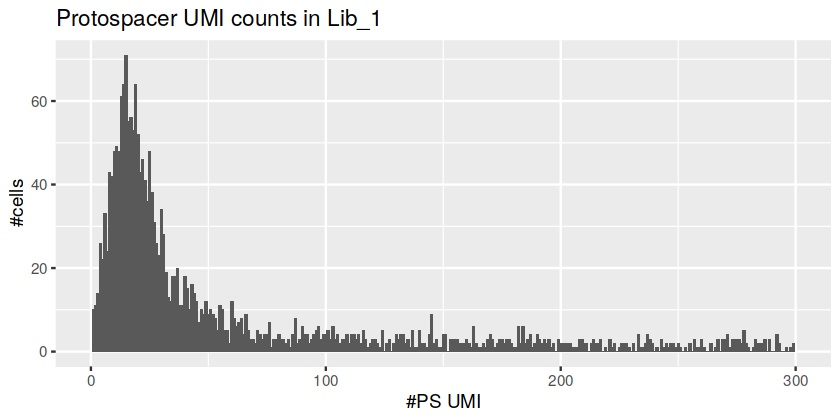

In [10]:
options(repr.plot.width=7, repr.plot.height=3.5)
title = paste("Protospacer UMI counts in", my_library)

ggplot(df_sums, aes(x = sgRNA_count)) +
    geom_histogram(binwidth=1) +
    labs(x = "#PS UMI") +
    labs(y = "#cells") + 
    labs(title = title) +
    xlim(0,300)

### How many cells with a count < 50?

In [11]:
cutoff = 50
n_low_count = sum(df_sums$sgRNA_count < cutoff)
num_cells = nrow(df_sums)
perc_low_count = round(100*n_low_count/num_cells,1)
cat(green(my_library, " ----------- \n"))
cat("#cells in library :")
cat(yellow(num_cells), "\n")
cat("#cells with #sgRNA <", cutoff, ": ")
cat(yellow(n_low_count), "\n")
cat("%cells with #sgRNA <", cutoff, ": ")
cat(yellow(paste0(perc_low_count, "%")), "\n")

Lib_1  ----------- 
#cells in library :7295 
#cells with #sgRNA < 50 : 1493 
%cells with #sgRNA < 50 : 20.5% 


### Identify zero-count guides

In [12]:
rownames(seurat_subset@misc$thresholds) <- seurat_subset@misc$thresholds$guide

In [13]:
guide_list = rownames(seurat_subset[['sgRNA']])
df_dummy = seurat_subset@misc$thresholds[guide_list, ]
seurat_subset@misc$thresholds[guide_list, ]


,guide,Lib_1,Lib_2,Lib_3,Lib_4
,<chr>,<int>,<int>,<int>,<int>
CD13-1a,CD13-1a,15,11,44,21
CD13-1b,CD13-1b,10,9,23,21
CD55-1a,CD55-1a,13,10,29,20
CD55-1b,CD55-1b,22,21,80,30
CD73-1a,CD73-1a,9,7,24,24
CD73-1b,CD73-1b,18,8,36,19
FUBP1-1a,FUBP1-1a,30,22,219,84
FUBP1-1b,FUBP1-1b,16,11,132,46
C15orf40-1a,C15orf40-1a,48,24,164,59


In [14]:
for(guide in guide_list) {
    s = sum(seurat_subset[['sgRNA']]@counts[guide, ] > 0)
    if(s == 0) {
        cat(green(guide), "\t", s, "\n") 
    } else {
        #cat(guide, "\t", s, "\n") 
    }
}


FTH1-2b 	 0 
DE2-1a 	 0 
DE2-1b 	 0 
DE9-2a 	 0 
DE9-2b 	 0 
DE16-2a 	 0 
NTCE1-1b 	 0 
NTCE2-1a 	 0 
NTCE2-1b 	 0 


### Find cells with zero calls

In [15]:
rownames(seurat_subset@misc$thresholds) <- seurat_subset@misc$thresholds$guide

In [16]:
guide_list = rownames(seurat_subset[['sgRNA']])
df_dummy = seurat_subset@misc$thresholds[guide_list, ]
#head(seurat_subset@misc$thresholds[guide_list, ])
thresholds_for_lib = seurat_subset@misc$thresholds[guide_list, my_library]
thresholds_for_lib[is.na(thresholds_for_lib)] = 1e50

In [17]:
ps_counts = t(seurat_subset[['sgRNA']]@counts)
select_zero_call_cells = rowSums(ps_counts >= thresholds_for_lib) == 0 
#zero_call_cells = rownames(ps_counts[select_zero_call_cells,])

In [18]:
thresholds_for_lib

[1] 1.5e+01 1.0e+01 1.3e+01 2.2e+01 9.0e+00 1.8e+01 3.0e+01 1.6e+01 4.8e+01
 [10] 4.3e+01 4.9e+01 1.9e+01 2.1e+01 1.4e+01 6.0e+00 1.0e+50 3.3e+01 2.2e+01
 [19] 6.0e+00 1.2e+01 7.0e+01 1.2e+01 1.6e+01 3.3e+01 4.4e+01 1.1e+01 1.2e+01
 [28] 8.0e+00 7.0e+00 1.8e+01 8.7e+01 7.0e+00 1.7e+01 1.8e+01 1.2e+02 7.0e+00
 [37] 2.7e+01 2.0e+01 2.6e+01 2.9e+01 1.6e+02 6.0e+00 5.1e+01 2.1e+01 1.0e+50
 [46] 1.0e+50 2.5e+01 1.8e+01 4.1e+01 1.8e+01 1.6e+01 1.1e+01 1.2e+01 5.0e+00
 [55] 3.4e+01 1.0e+01 4.5e+01 2.9e+01 5.2e+01 4.1e+01 2.3e+01 1.5e+01 1.6e+01
 [64] 1.0e+50 4.7e+01 1.1e+01 1.7e+01 1.9e+01 3.4e+01 2.0e+01 4.9e+01 2.3e+01
 [73] 3.4e+01 7.0e+00 1.0e+50 1.0e+50 4.9e+01 1.6e+01 1.0e+01 1.5e+01 3.5e+01
 [82] 5.0e+00 2.2e+01 1.7e+01 1.3e+01 4.7e+01 4.0e+00 1.3e+01 2.3e+01 5.9e+01
 [91] 6.0e+00 1.5e+01 2.2e+01 1.2e+01 2.4e+01 2.7e+01 1.8e+01 9.0e+00 1.3e+01
[100] 1.7e+01 2.2e+01 1.4e+01 1.0e+50 1.7e+01 1.6e+01 1.2e+01 7.8e+01 2.5e+01
[109] 3.0e+01 1.0e+50 1.0e+50 1.0e+50 3.5e+01 5.0e+01 2.5e+01 2.0e+01 1.5e+01
[118] 2.4e+01 3.1e+01 8.0e+00 2.2e+01 1.0e+01 3.5e+01 2.5e+01 4.1e+01 2.6e+01
[127] 3.1e+01 8.0e+00 2.5e+01 3.6e+01 2.8e+01 6.0e+00

#### Check a non-zero-call cell first

In [19]:
cell_no = 1
select_guides_w_call = ps_counts[cell_no, ] >= thresholds_for_lib
guides_and_counts = ps_counts[cell_no, select_guides_w_call]
print(guides_and_counts)

FUBP1-1a   DE6-2a   DE8-1a   DE8-1b  DE15-2b 
     941      248      953      446      628 


In [20]:
head(seurat_subset,1)

,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,nCount_SCT,nFeature_SCT,orig.ident,library,percent.mt,status,donor,dCas9,SCT_snn_res.0.5,seurat_clusters,guide_calls,plasmid_calls,n_guides,n_plasmids
,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>
AAACCCAAGAGCAGCT-1_1,25185,5887,3237,19,24864,5840,Screen1_66guides,Lib_1,6.7,singlet,3,20,1,1,FUBP1-1a|DE6-2a|DE8-1a|DE8-1b|DE15-2b,FUBP1-1|DE6-2|DE8-1|DE15-2,5,4


### Pick a cell with zero calls

In [21]:
zero_call_cells = rownames(seurat_subset@meta.data[(seurat_subset$n_plasmids == 0),])

In [22]:
cell_no = 2
cell_barcode = zero_call_cells[[cell_no]]
select_called_guides = ps_counts[cell_barcode, ] >= thresholds_for_lib
n_called_guide = sum(select_called_guides)
print(n_called_guide)

[1] 0


### Loop over all cells, check if zero-call cells match the get_perturbed_cells() calls

In [23]:
n_zero_calls = 0
for(cell_barcode in colnames(seurat_subset)) {
    select_called_guides = ps_counts[cell_barcode, ] >= thresholds_for_lib
    n_called_guides = sum(select_called_guides)
    #cat(".")
    if(n_called_guides == 0) {
        n_zero_calls = n_zero_calls + 1
        if(!cell_barcode %in% zero_call_cells) {            
            print("Cell is not in zero-call cells!!!")
            print(cell_barcode)
            select_nonzero_guides =
                ps_counts[cell_barcode, ] > thresholds_for_lib
            print(ps_counts[cell_barcode, select_nonzero_guides])
        }
    }
    else {
        if(cell_barcode %in% zero_call_cells) {
            print("Cells has no called-guides but is IN zero-call cells!!!")
            print(cell_barcode)
            #print(cell_barcode == zero_call_cells)
            break
        }
    }
}
print(n_zero_calls)

[1] 1721


Does the number match get_perturbed_cells() number? Yes

In [24]:
sum(seurat_subset$n_plasmids == 0) == n_zero_calls

[1] TRUE

### Inspect the counts for no-call cells

In [25]:
df_sums = data.frame(
    colSums(seurat_subset[["sgRNA"]]@counts[, zero_call_cells])
)
colnames(df_sums) = "sgRNA_count"

Warning message:
"Removed 1 rows containing non-finite values (`stat_bin()`)."


Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


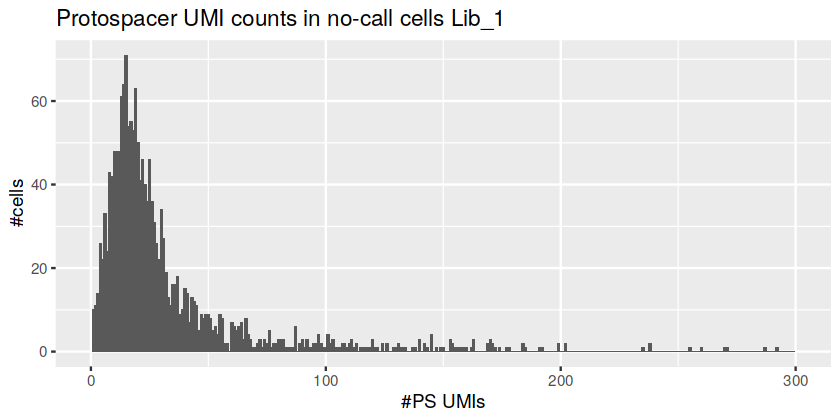

In [26]:
options(repr.plot.width=7, repr.plot.height=3.5)
title = paste("Protospacer UMI counts in no-call cells", my_library)

ggplot(df_sums, aes(x = sgRNA_count)) +
    geom_histogram(binwidth=1) +
    labs(x = "#PS UMIs") +
    labs(y = "#cells") + 
    labs(title = title) +
    xlim(0,300)

In [27]:
nrow(df_sums)

[1] 1721

#### Inspect the total guide counts again

In [28]:
df_sums = data.frame(rowSums(seurat_subset[['sgRNA']]@counts))
colnames(df_sums) = "total_count"
df_sums$protospacer = rownames(df_sums)

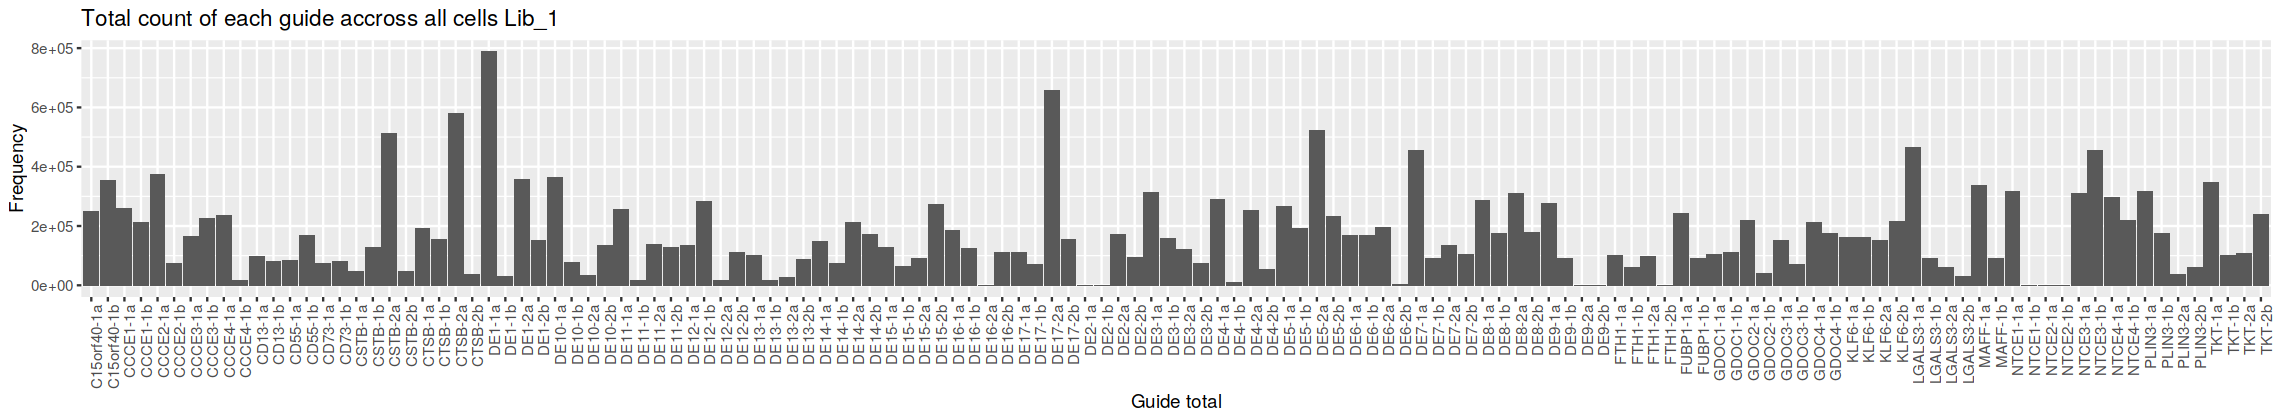

In [29]:
options(repr.plot.width=19, repr.plot.height=3.5)
df_sums = df_sums %>% arrange(total_count, desc=T)

title = paste("Total count of each guide accross all cells", my_library)

ggplot(df_sums, aes(y = total_count, x = protospacer)) +
    geom_bar(stat='identity') +
    labs(x = "Guide total") +
    labs(y = "Frequency") + 
    labs(title = title) +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) 

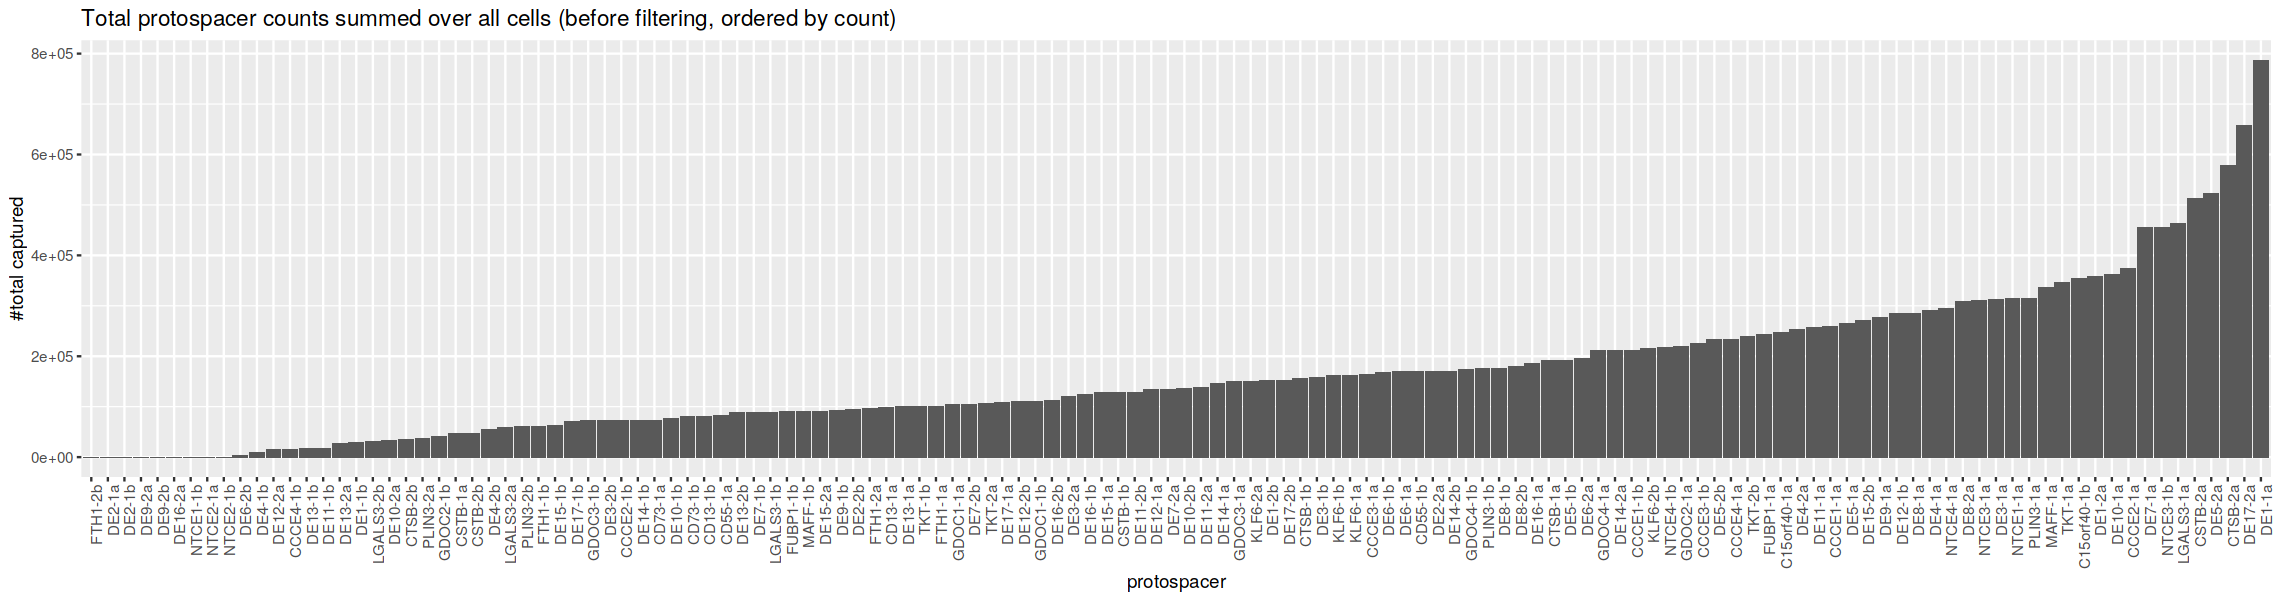

In [30]:
df_sums$protospacer <- factor(df_sums$protospacer, levels = df_sums$protospacer)

options(repr.plot.width=19, repr.plot.height=5)
ggplot(df_sums, aes(x=protospacer, y=total_count)) +
    geom_bar(stat='identity') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(
        title = "Total protospacer counts summed over all cells " %+% 
                "(before filtering, ordered by count)", x = "protospacer"
    ) +
    labs(y = "#total captured") 

In [31]:
head(df_sums %>% arrange(total_count), 15)

,total_count,protospacer
,<dbl>,<fct>
FTH1-2b,0,FTH1-2b
DE2-1a,0,DE2-1a
DE2-1b,0,DE2-1b
DE9-2a,0,DE9-2a
DE9-2b,0,DE9-2b
DE16-2a,0,DE16-2a
NTCE1-1b,0,NTCE1-1b
NTCE2-1a,0,NTCE2-1a
NTCE2-1b,0,NTCE2-1b
